## Pipeline with breast cancer data of cBioPortal to check link between high proliferation/ Invasion and low Apoptosis with worse survival outcome

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import maboss
import gseapy as gp
from scipy.stats import spearmanr
import pandas as pd
import os
from pathlib import Path

from functions.validation_utils.validation_Breast import (
    process_montagud_nodes,process_montagud_nodes_synonyms, process_genes, pre_process_mutations, preprocess_cnv,create_generic_patients_cfgs_bnds, personalized_patients_genes_cfgs, generic_models_update_phenotypes, tailor_bnd_cnv_cm, correlate_boolean_predictions_with_gene_signatures, compute_phenotype_table, combine_patient_results, survival_analysis_comparison
)


from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import collect_group_data

In [2]:
import logging

logger = logging.getLogger(__name__)

### Loading the dataset

In [3]:
#  somatic mutations, copy number alterations, and gene expression
# 2509 models


# genes_data = pd.read_csv('data/cBioPortal/data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt', sep='\t')


import pandas as pd
import os
# try with raw data
rna_seq_breast = pd.read_csv('data/cBioPortal/data_mrna_illumina_microarray.txt',sep='\t')

mutations_data = pd.read_csv('data/cBioPortal/data_mutations.txt', sep='\t', skiprows=1)
cnv_data = pd.read_csv('data/cBioPortal/data_cna.txt', sep='\t')
clinical_patients_data = pd.read_csv('data/cBioPortal/data_clinical_patient.txt', sep='\t',skiprows=4)
clinical_samples = pd.read_csv('data/cBioPortal/data_clinical_sample.txt',sep='\t',skiprows=4)
nodes_montagud_synonyms = pd.read_csv('data/fumia_models/nodes_processed.txt',sep='\t')


montagud_original_data_df = (
    pd.read_csv('data/montagud_models/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])




onco_tsg_data = pd.read_csv('data/oncogenes_tsg.tsv',sep='\t')

from functions.validation_utils.validation_Breast import process_montagud_nodes_synonyms, process_montagud_nodes, process_genes, preprocess_cnv, pre_process_mutations, create_generic_patients_cfgs_bnds, generic_models_update_phenotypes, tailor_bnd_cnv_cm, personalized_patients_genes_cfgs, compute_phenotype_table, survival_analysis_comparison, combine_patient_results, correlate_boolean_predictions_with_gene_signatures

In [4]:
def main_validation(normalization_method, nb_patient, rna_seq_breast, discrete_variable, continuous_variable, phenotypes_interest, inputs_list):
    folder_generic_models = 'data/fumia_models'
    folder_models = f'analysis/validation_Breast/{discrete_variable}_{continuous_variable}/{normalization_method}/models'
    results_folder = f'analysis/validation_Breast/{discrete_variable}_{continuous_variable}/{normalization_method}/results'


    os.makedirs(folder_models, exist_ok=True)
    type_personalization = discrete_variable

    clinical_patients_data_test = clinical_patients_data[clinical_patients_data['NPI'].notna()]
    clinical_patients_data_test = clinical_patients_data_test[['PATIENT_ID', 'NPI', 'OS_MONTHS', 'OS_STATUS']]
    clinical_patients_data_test = clinical_patients_data_test[clinical_patients_data_test['OS_MONTHS'].notna() & clinical_patients_data_test['OS_STATUS'].notna()]

    # Sort by NPI
    clinical_sorted = clinical_patients_data_test.sort_values('NPI')

    # Select lowest NPI (best prognosis)
    nb_patient_group = nb_patient// 2
    low_npi_patients = clinical_sorted.head(nb_patient_group)['PATIENT_ID'].tolist()

    # Select highest NPI (worst prognosis)  
    high_npi_patients = clinical_sorted.tail(nb_patient_group)['PATIENT_ID'].tolist()
    patients_ids = low_npi_patients + high_npi_patients


    # Keep Hugo_Symbol, Entrez_Gene_Id, and patient columns
    rna_seq_breast_filtered = rna_seq_breast[['Hugo_Symbol', 'Entrez_Gene_Id'] + 
                                [col for col in rna_seq_breast.columns if col in patients_ids]]


    cnv_data_filtered = cnv_data[['Hugo_Symbol', 'Entrez_Gene_Id'] + 
                                [col for col in cnv_data.columns if col in patients_ids]]


    mutations_data_filtered = mutations_data[mutations_data['Tumor_Sample_Barcode'].isin(patients_ids)]

    clinical_patients_data_filtered = clinical_patients_data[clinical_patients_data['PATIENT_ID'].isin(patients_ids)]


    montagud_node_synonyms, synonyms_to_nodes_dict = process_montagud_nodes_synonyms(nodes_montagud_synonyms)
    montagud_node_model, all_montagud_nodes = process_montagud_nodes(
        montagud_original_data_df, montagud_node_synonyms)
    
    
    rna_seq_data_final = process_genes(patients_ids, rna_seq_breast_filtered, all_montagud_nodes, synonyms_to_nodes_dict)
    cnv_data_filt = preprocess_cnv(patients_ids, cnv_data_filtered, all_montagud_nodes, synonyms_to_nodes_dict)
    mutations_data_filtered =  pre_process_mutations(patients_ids, mutations_data_filtered, onco_tsg_data, all_montagud_nodes, synonyms_to_nodes_dict)


    create_generic_patients_cfgs_bnds(
    folder_generic_models,
    folder_models,
    patients_ids,
)
    
    generic_models_update_phenotypes(phenotypes_interest, folder_models)

    if discrete_variable == 'mutations':
        tailor_bnd_cnv_cm(mutations_data_filtered, folder_models)
        logger.debug('mutations selected')

    elif discrete_variable == 'cnv':
        tailor_bnd_cnv_cm(cnv_data_filt, folder_models)
        logger.debug('cnv selected')
    elif discrete_variable == 'cnv_mutations':
        tailor_bnd_cnv_cm(cnv_data_filt, folder_models)
        tailor_bnd_cnv_cm(mutations_data_filtered, folder_models)
        logger.debug('mutations and cnv selected')

    else:
        logger.debug('select between mutations or cnv or cnv_mutations')

    personalized_patients_genes_cfgs(
    rna_seq_data_final,
    all_montagud_nodes,
    folder_models,
    amplif_factor = 100,
    normalization_method = normalization_method
)
    
    for patient in patients_ids:
        results_maboss = compute_phenotype_table(
            results_folder,
            folder_models,
            patient,
            inputs_list,
            phenotypes_interest,
        )
    combined_results = combine_patient_results(results_folder)
    # combined_results = pd.read_csv('analysis/validation_Breast/mutations_genes/sigmoid/results/combined_patients_ids.csv')

        # Create groups based on proliferation level and then apoptosis level
    combined_results_survival = combined_results.copy()
    combined_results_survival['Group_Proliferation'] = np.where(
        combined_results_survival['Proliferation'] < combined_results['Proliferation'].mean(), 
        'low', 
        'high'
    )

    # You can also create groups for Apoptosis
    combined_results_survival['Group_Apoptosis'] = np.where(
        combined_results_survival['Apoptosis'] < combined_results['Apoptosis'].mean(), 
        'low', 
        'high'
    )

    # Processing survival data

    survival_columns = [
        'PATIENT_ID',           # Patient identifier
        'OS_MONTHS',            # Overall survival time (months)
        'OS_STATUS',            # Overall survival status (0=alive, 1=dead)
    ]

    clinical_patients_data_filtered = clinical_patients_data_filtered[survival_columns]
    clinical_patients_ids = list(set(clinical_patients_data_filtered['PATIENT_ID']))


    # merge the two 
    # Same as above but using the dataframe method
    survival_analysis_data = clinical_patients_data_filtered.merge(
        combined_results, 
        left_on='PATIENT_ID', 
        right_on='patient_id', 
        how='inner'
    )


    survival_analysis_data['OS_STATUS'] = survival_analysis_data['OS_STATUS'].map({
            '0:LIVING': 0,
            '1:DECEASED': 1,
            'LIVING': 0,
            'DECEASED': 1,
            0: 0,
            1: 1
        })


    survival_analysis_data['Group_Proliferation'] = np.where(
        survival_analysis_data['Proliferation'] < survival_analysis_data['Proliferation'].median(), 
        'low', 
        'high'
    )

    # You can also create groups for Apoptosis using median
    survival_analysis_data['Group_Apoptosis'] = np.where(
        survival_analysis_data['Apoptosis'] < survival_analysis_data['Apoptosis'].median(), 
        'low', 
        'high'
    )

    # Use the updated function
    survival_analysis_comparison(
        normalization_method,
        discrete_variable,
        continuous_variable,
        survival_analysis_data, 
        'Group_Proliferation', 
        save_plots=True
    )

    survival_analysis_comparison(
        normalization_method,
        discrete_variable,
        continuous_variable,
        survival_analysis_data, 
        'Group_Apoptosis',
        save_plots=True
    )




    rna_seq_breast_filtered['Hugo_Symbol'] = rna_seq_breast_filtered['Hugo_Symbol'].str.strip()

        # Transform from wide to long format
    rna_seq_data_long = rna_seq_breast_filtered.melt(
        id_vars=['Hugo_Symbol', 'Entrez_Gene_Id'],  # Keep these columns as identifiers
        value_vars=rna_seq_breast_filtered.columns[2:],  # Patient columns to melt
        var_name='patient_id',  # Name for the new column containing patient IDs
        value_name='expression_value'  # Name for the new column containing expression values
    )

    rna_seq_data_final = rna_seq_data_long[['patient_id', 'Hugo_Symbol', 'expression_value']]
    rna_seq_data_final = rna_seq_data_final.rename(columns={'Hugo_Symbol': 'gene_symbol', 'patient_id':'model_id', 'expression_value':'rsem_tpm'})
    
     # Strip whitespace from gene_symbol column
    rna_seq_data_final['gene_symbol'] = rna_seq_data_final['gene_symbol'].str.strip()


    results_corr_apoptosis_df, correlation_data = correlate_boolean_predictions_with_gene_signatures(True, combined_results, 'Apoptosis', 'Apoptosis', rna_seq_breast, patients_ids)
    results_corr_prolife_df, correlation_data = correlate_boolean_predictions_with_gene_signatures(True, combined_results, 'G2-M Checkpoint', 'Proliferation', rna_seq_breast, patients_ids)
    results_corr_apoptosis_df.to_csv(f'{results_folder}/outputs/results_corr_apoptosis_df')
    results_corr_prolife_df.to_csv(f'{results_folder}/outputs/results_corr_prolife_df')



    # correlation to NIP 
    clinical_patients_data_NPI = clinical_patients_data[clinical_patients_data['PATIENT_ID'].isin(patients_ids)]
    clinical_patients_data_NPI = clinical_patients_data_NPI[['PATIENT_ID', 'NPI']]

    clinical_patients_data_NPI = clinical_patients_data_NPI.merge(
        combined_results, 
        left_on='PATIENT_ID', 
        right_on='patient_id'
    )

    phenotypes_list = ['Proliferation', 'Apoptosis']
    corr_NPI_results_df = pd.DataFrame(index=phenotypes_list, columns = ['Correlation', 'P-value'])

    for phenotype in phenotypes_list:
        corr, pval = spearmanr(list(clinical_patients_data_NPI['NPI']), list(clinical_patients_data_NPI[phenotype]))
        corr_NPI_results_df.loc[phenotype, 'Correlation'] = corr
        corr_NPI_results_df.loc[phenotype, 'P-value'] = pval
    results_folder_output = f'{results_folder}/outputs/NPI_correlation.csv'
    corr_NPI_results_df.to_csv(results_folder_output)





/Users/romane/repos/icr/Attractor-Resistance/functions/validation_utils/validation_Breast.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data_filtered['Hugo_Symbol'] = rna_seq_data_filtered['Hugo_Symbol'].str.strip()


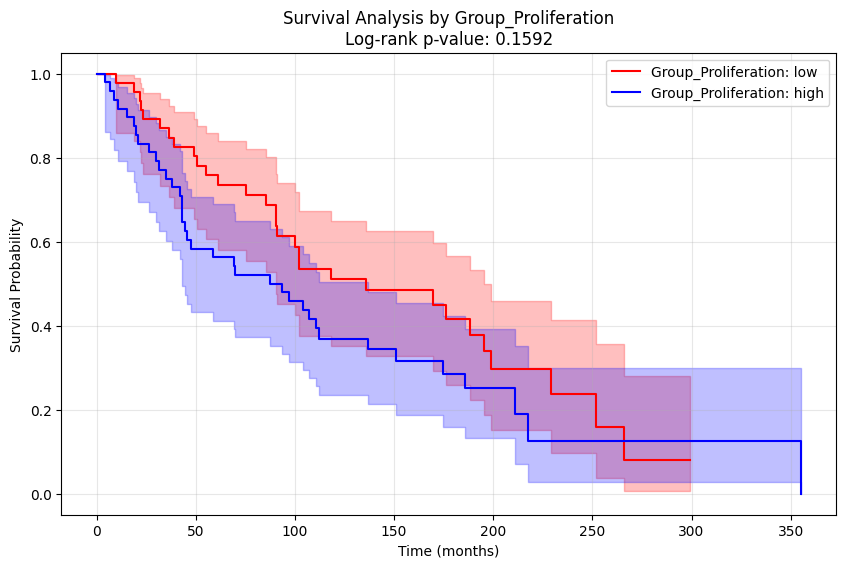

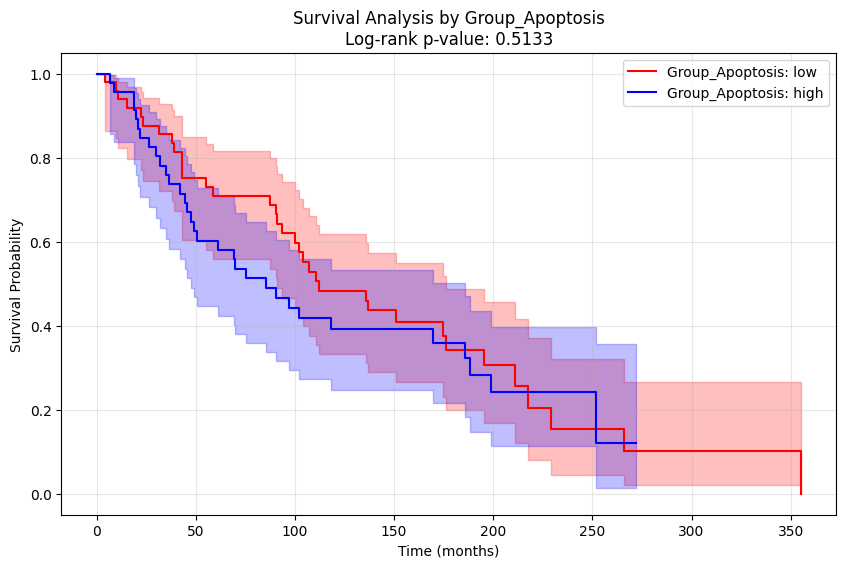

/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_7166/501996681.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_breast_filtered['Hugo_Symbol'] = rna_seq_breast_filtered['Hugo_Symbol'].str.strip()


In [5]:
import os
import numpy as np

nb_patient = 100
# discrete_variables = ['mutations', 'cnv']

discrete_variables = ['cnv_mutations']

continuous_variable = 'genes'

phenotypes_interest = ["Proliferation","Apoptosis"]
inputs_list = ['GLI', 'MAX', 'PTEN', 'Acidosis', 'p14ARF', 'ROS', 'Hypoxia', 'Nutrients', 'Carcinogen', 'GFs', 'TNFalpha']

normalization_techniques = ['sigmoid']


# normalization_techniques = ['sigmoid', 'min-max','log_transf','global_minmax', 'global_log']

for normalization_method in normalization_techniques:
    for discrete_variable in discrete_variables:
        main_validation(normalization_method, nb_patient, rna_seq_breast, discrete_variable, continuous_variable, phenotypes_interest, inputs_list)



## Correlation to the NPI values

# inactivating mutations (nonsense, frame-shift insertions or deletions and mutation in splice or translation start sites)



# === Assumption ===
# mutations targeting oncogenes -> gain of function
# mutations targeting Tumor suppressor genes -> loss of function


# SIFT and  PolyPhen scores

